In [24]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial.distance
import time
import bats

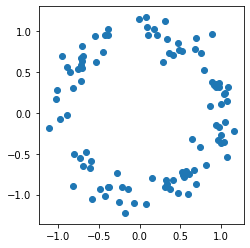

In [19]:
# first, generate a circle
n = 100
X = np.random.normal(size=(n,2))
X = X / np.linalg.norm(X, axis=1).reshape(-1,1)
X = X + np.random.normal(size=(n,2), scale = 0.1 )
fig = plt.scatter(X[:,0], X[:,1])
fig.axes.set_aspect('equal')

Time: 7.0 seconds


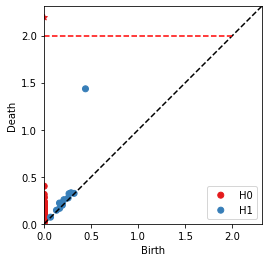

In [28]:
# use bats to compute distances internally
start = time.time()
data = bats.DataSet(bats.Matrix(X)) # put into a bats.DataSet
dist = bats.Euclidean()  # distance we would like to use
F = bats.RipsFiltration(data, dist, np.inf, 2) # generate a RipsFiltration

R = bats.reduce(F, bats.F2()) # reduce with F2 coefficients
ps = []
for d in range(R.maxdim()):
    ps.extend(R.persistence_pairs(d))

fig, ax = bats.persistence_diagram(ps, tmax = 2.0)
# plt.savefig('figures/RipsEx_pd_euc.png')

print("Time: {:.1f} seconds".format(time.time() - start))

In [29]:
# method 1: use bats to get pairwise distances
start = time.time()
data = bats.DataSet(bats.Matrix(X)) # put into a bats.DataSet
dist = bats.Euclidean()  # distance we would like to use
pdist = dist(data, data) # returns a bats.Matrix of pairwise distances

print("Time: {:.1f} seconds".format(time.time() - start))

Time: 0.0 seconds


In [30]:
# method 2: use scipy to get pairwise distances
start = time.time()
pdist_sp = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(X, 'euclidean'))
pdist = bats.Matrix(pdist_sp)

print("Time: {:.1f} seconds".format(time.time() - start))

Time: 0.0 seconds


Time: 0.8 seconds


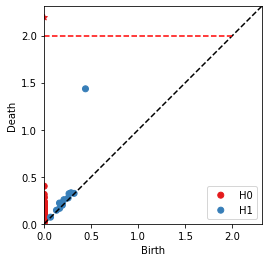

In [34]:
start = time.time()
rmax = np.min(np.max(pdist_sp, axis=1))
# rmax = np.inf
F = bats.RipsFiltration(pdist, rmax, 2) # generate a filtration on pariwise distances
R = bats.reduce(F, bats.F2()) # reduce with F2 coefficients
ps = []
for d in range(R.maxdim()):
    ps.extend(R.persistence_pairs(d))

fig, ax = bats.persistence_diagram(ps, tmax = 2.0)
# plt.savefig('figures/RipsEx_pd.png')

print("Time: {:.1f} seconds".format(time.time() - start))

In [10]:
# inds is sequence of indices selected by greedy landmarking
# dists[k] is hausdorff distance from X[inds[:k]] to X
inds, dists = bats.greedy_landmarks_hausdorff(pdist, 0) # 0 is first index

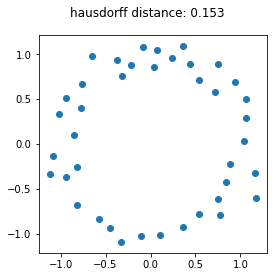

In [12]:
k = 40 # we'll landmark 40 points
# print('hausdorff distance is {}'.format(dists[k]))
fig = plt.figure()
ret = plt.scatter(X[inds[:k],0], X[inds[:k],1])
fig.suptitle('hausdorff distance: {:.3f}'.format(dists[k]))
ret.axes.set_aspect('equal')
# plt.savefig('figures/RipsEx_data_landmark.png')

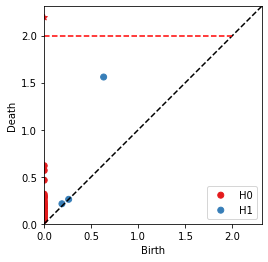

In [14]:
# use scipy to get pairwise distances
pdist_sp = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(X[:k], 'euclidean'))
pdist = bats.Matrix(pdist_sp)

F = bats.RipsFiltration(pdist, np.inf, 2) # generate a filtraiton on pariwise distances
R = bats.reduce(F, bats.F2()) # reduce with F2 coefficients
ps = []
for d in range(R.maxdim()):
    ps.extend(R.persistence_pairs(d))

fig, ax = bats.persistence_diagram(ps, tmax = 2.0)
# plt.savefig('figures/RipsEx_pd_landmark.png')

In [60]:
import plotly
import plotly.graph_objects as go

def rips_result(X):
    # use bats to get pairwise distances
    data = bats.DataSet(bats.Matrix(X)) # put into a bats.DataSet
    dist = bats.L1Dist()  # distance we would like to use
    pdist = dist(data, data) # returns a bats.Matrix of pairwise distances

    pdist_np = np.array(pdist) # numpy array of pairwise distances
    
    rmax = np.min(np.max(pdist_np, axis=1))
#     rmax = np.inf
    F = bats.RipsFiltration(pdist, rmax, 2) # generate a filtraiton on pariwise distances
    R = bats.reduce(F, bats.F2()) # reduce with F2 coefficients

    # get longest H1 pair
    ps1 = R.persistence_pairs(1)
    lens = [p.death() - p.birth() for p in ps1] # find longest length pair
    ind = np.argmax(lens)
    pair = ps1[ind]
    
    return F, R, pair, pdist_np


def plot_representative_2D(X, F, R, pair, D, thresh=None, **kwargs):
    """
    Plot H1 represnetative on 2D scatter plot

    plot representative
    X: 2-dimensional locations of points
    F: bats FilteredSimplicialComplex
    R: bats ReducedFilteredChainComplex
    pair: bats PersistencePair
    D: N x N distance matrix
    thresh: threshold parameter
    kwargs: passed onto figure layout
    """
    if thresh is None:
        thresh = pair.birth()

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=X[:,0], y=X[:,1],
        mode='markers',
    ))
    edge_x = []
    edge_y = []
    N = X.shape[0]
    for i in range(N):
        for j in range(N):
            if D[i, j] <= thresh:
                edge_x.extend([X[i,0], X[j,0], None])
                edge_y.extend([X[i,1], X[j,1], None])

    fig.add_trace(go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')
     )

    edge_x = []
    edge_y = []
    r = R.representative(pair)
    nzind = r.nzinds()
    cpx = F.complex()
    for k in nzind:
        [i, j] = cpx.get_simplex(1, k)
        if D[i, j] <= thresh:
            edge_x.extend([X[i,0], X[j,0], None])
            edge_y.extend([X[i,1], X[j,1], None])
    fig.add_trace(go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=2, color='red'),
        hoverinfo='none',
        mode='lines')
     )
    fig.update_layout(**kwargs)
    return fig

F, R, pair, D = rips_result(X)

fig = plot_representative_2D(X, F, R, pair, D, width=800, height=800)
# fig.write_image('figures/H1_rep.png')

In [61]:
fig.show()

In [39]:
y = np.array([[0,2,3],[2,0,4],[3,4,0]])
scipy.spatial.distance.squareform(y)

array([2, 3, 4])

In [48]:
X.shape

(100, 2)

In [49]:
pdist_np.shape

(100, 100)